# DataLab Cup 1: Text Feature Engineering

Course: CS565500

Platform: [Kaggle](https://www.kaggle.com/competitions/2024-datalab-cup1)

Student Name: Sao Hsuan Lin (林劭軒)

Student ID: 113062532

## Data Preprocessing

I have written a library for extracting features from the html data.

In short, the library does:
- Read the input csv file
- Extract features from each row in parallel using `multiprocessing`
- Cache the extracted features to an other csv file

The features I extracted are:
- Datetime
  - Extract year, month, day, hour, weekday, minute, second from the `time` tag.
- Channel
  - Extract the `data-channel` attribute from the `article` tag.
- Categories
  - Extract the `href` attribute from the `a` tag under tag `footer` with class `article-topics`.
  - Since each row may have multiple categories, I encode with multi-hot encoding.
  - Besides, the number of categories is too large, so the library allows to set a threshold to filter out categories with low frequency.
- Token Count
  - Count the number of tokens of the given selector.
  - Variants
    - Token count
    - Unique token count
    - Non-stopword token count
    - Non-stopword unique token count
- TextBlob
  - Sentiment polarity and subjectivity of the given selector.
- SentimentIntensityAnalyzer.polarity_scores
  - neg, neu, pos, compound of the given selector.
- textstat.flesch_reading_ease
  - The readability of the given selector.

Plot of top 100 correlation of features with the target:

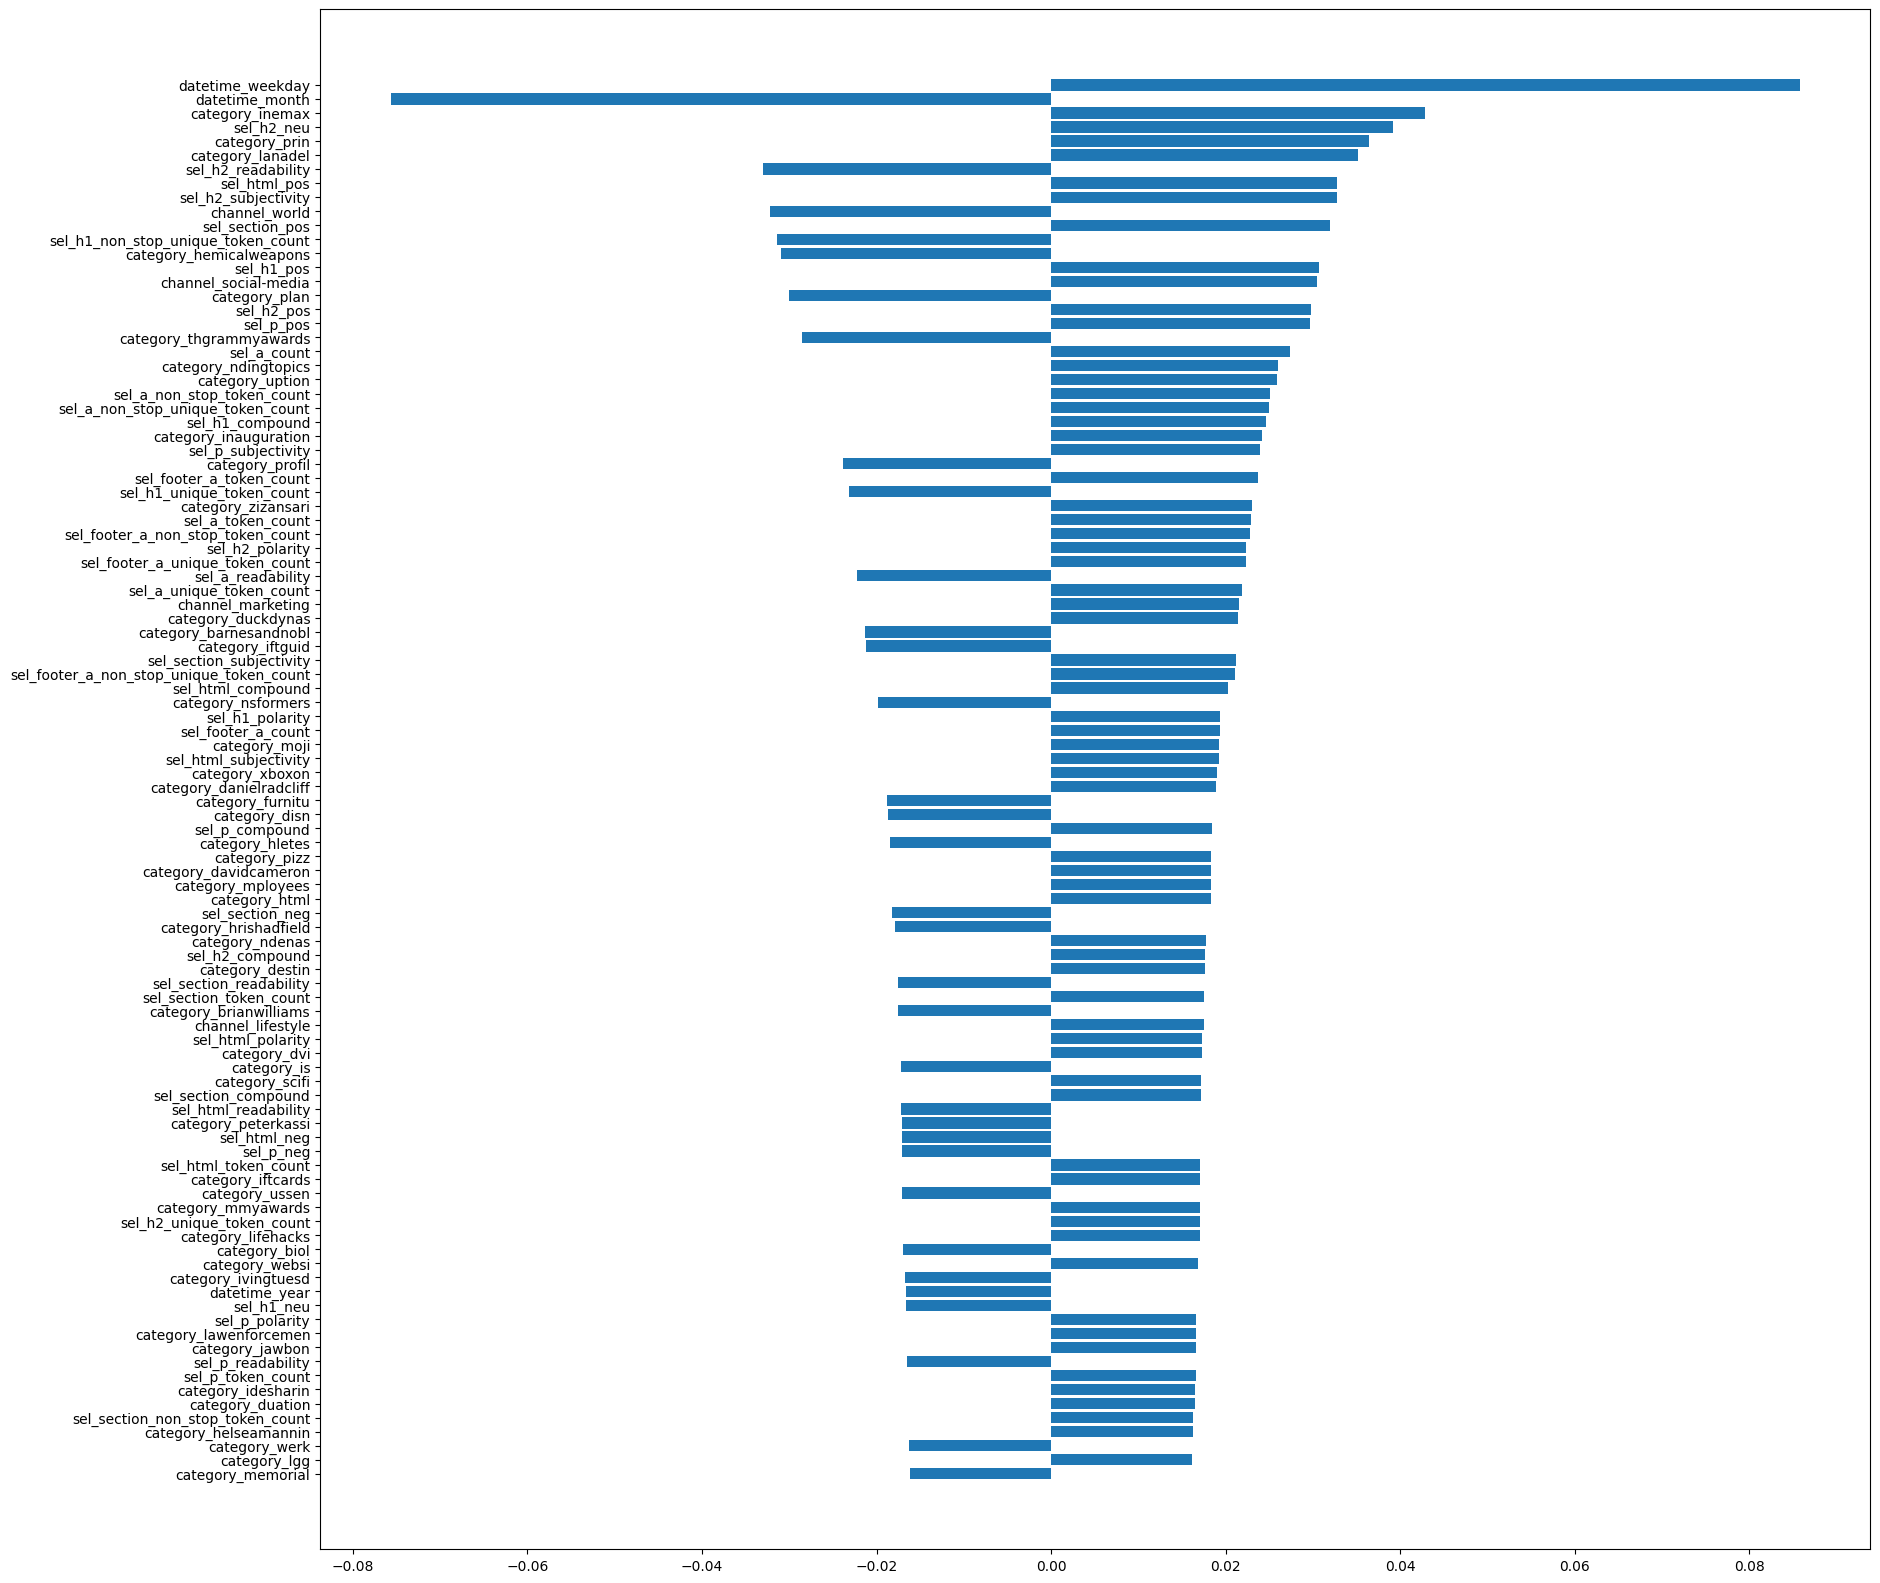

## Model

Models tested:
- `LogisticRegression`
- `CatBoostClassifier`
- `XGBClassifier`
- `LGBMClassifier`
- `VotingClassifier`
  - Base models: `LogisticRegression`, `CatBoostClassifier`, `XGBClassifier`, `LGBMClassifier`


## Infrastructure

- To perform multiple experiments with fine logging, I use `mlflow` to log the experiment results.
  - The components are `mlflow`, `postgresql`, `minio`
  - Built with `docker-compose`
  - [github (dasbd72/ml-infra)](https://github.com/dasbd72/ml-infra)
- Each cross-validation result is logged to the `mlflow` server.
- Each fold result is logged as a child run of the parent cross-validation run.
- Runs
  
   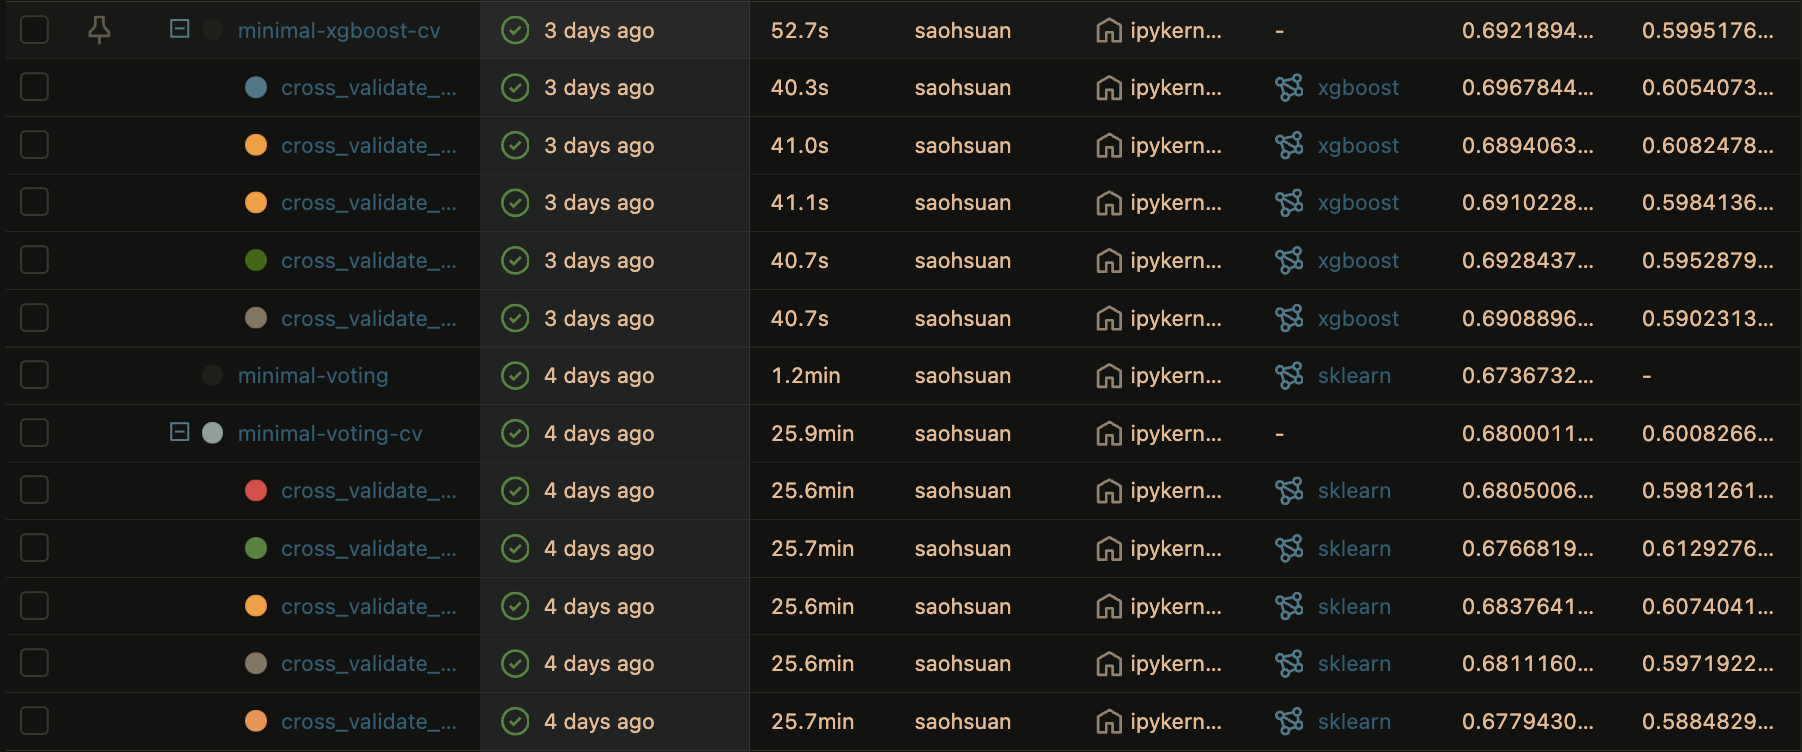


## Training and Evaluation

1. Pick the features to use
   - Though I have extracted many features, I only use a few of them.
   - I chose which features to use by training multiple models and comparing the performance using different features combinations, each model training are evaluated with 5-fold cross-validation.
   - Final features chosen:
     - `year`, `month`, `day`, `hour`, `weekday`
     - `channel`
     - `categories`
2. Base model hyperparameter tuning
   - I use `ParameterGrid` to search for the best hyperparameters for each base model.
   - The hyperparameters are searched with 5-fold cross-validation.
   - Implemented myself to make use of both parallelism and mlflow logging.
3. Applying base models in VotingClassifier
    - Use the best hyperparameters found in the previous step for the base models.
    - Train the `VotingClassifier` with the models.
    - Tries different combinations of the base models.
    - The best combination is 2 `XGBClassifier` and 3 `LGBMClassifier`.

## Conclusions

- About features
  - **The most important, more features do not always mean better.**
  - Tried one-hot encoding weekday and month, but the performance is worse than using them as numerical features.
- Engineering
  - Having nice infrastructure helps a lot in managing experiments, saves lots of time.
  - Writing good libraries for feature extraction (cachine and parallelism) can save time and make the notebooks cleaner.
- Model selection
  - The gradient boosting family models are so powerful.
  - Cross-validation is important to avoid overfitting on part of the validation set, although it is time-consuming, it is worth it.